In [1]:
import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde, gamma, uniform, rv_continuous, multivariate_normal, norm
from scipy.linalg import cholesky, LinAlgError, eigvalsh, eigh, inv
from scipy.special import gamma as gamma_func
from scipy.special import kv
import matplotlib.pyplot as plt
import emcee as em
from schwimmbad import MPIPool
import sys
import os
import corner

params = {'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.fontsize': 16,
          'font.size': 16,
          'legend.fancybox': True,
          'axes.grid': True}

plt.rcParams.update(params)

# Kernel tests

In [2]:
def rbf(theta,x):
    
    return theta[0]**2 * np.exp(-0.5 * theta[1]**-2 * np.subtract.outer(x,x)**2)

def periodic(theta,x):
    
    return theta[0]**2 * np.exp(-2 * theta[1]**-2 * np.sin(np.pi * np.subtract.outer(x,x) / theta[2])**2)

def local_periodic(theta,x):
    
    return rbf(theta,x) * periodic(theta,x)

def matern(theta, x):
    
    if theta[1] > 18:
        return rbf([theta[0], theta[2]], x)
    else:
        u = np.sqrt(2 * theta[1]) * abs(np.subtract.outer(x,x) / theta[2])
        u[u == 0.0] += np.finfo(float).eps
        K = theta[0] * 2**(1-theta[1]) / gamma_func(theta[1]) * (u)**theta[1] * kv(theta[1], u)

        return K

In [3]:
x = np.arange(0,10.01,0.01)
y = np.flip(x)
xx, yy = np.meshgrid(x,y)
f_avg = np.zeros(len(x))


theta_rbf = [1,1]
theta_per = [1,1,1]
theta_mat = [1,1,1]

## RBF

In [6]:
np.random.seed(42)
rbf_cov = rbf(theta_rbf, x)
y_rbf = multivariate_normal.rvs(mean=f_avg, cov=rbf_cov, size=3)

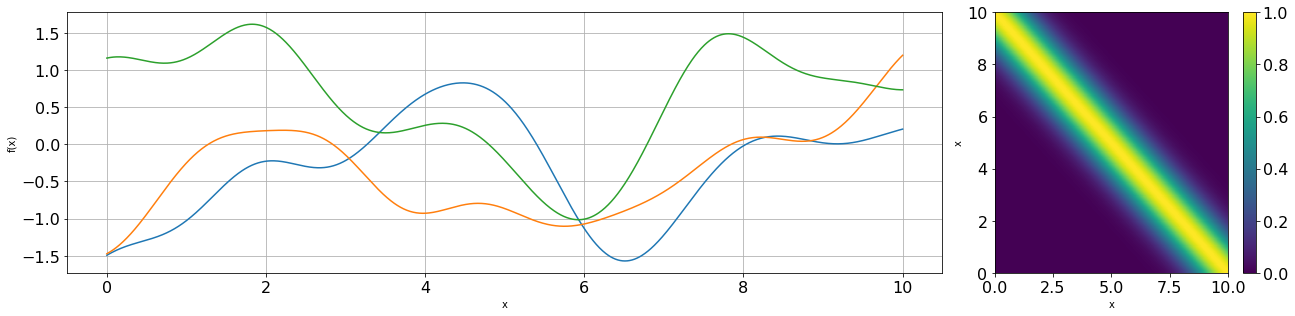

In [7]:
fig1, ax1 = plt.subplots(ncols=2, figsize=(18,4.5), gridspec_kw={'width_ratios': [3, 1]})
ax11, ax12 = ax1.flatten()

for i in y_rbf:
    ax11.plot(x, i)

p_rbf = ax12.pcolormesh(xx, yy, rbf_cov)
ax11.set(xlabel=r'x', ylabel=r'f(x)')
ax12.set(xlabel=r'x',ylabel=r'x')
fig1.colorbar(p_rbf)
fig1.tight_layout()

## Local Periodic

In [8]:
np.random.seed(42)
per_cov = local_periodic(theta_per, x)
y_per = multivariate_normal.rvs(mean=f_avg, cov=per_cov, size=3)

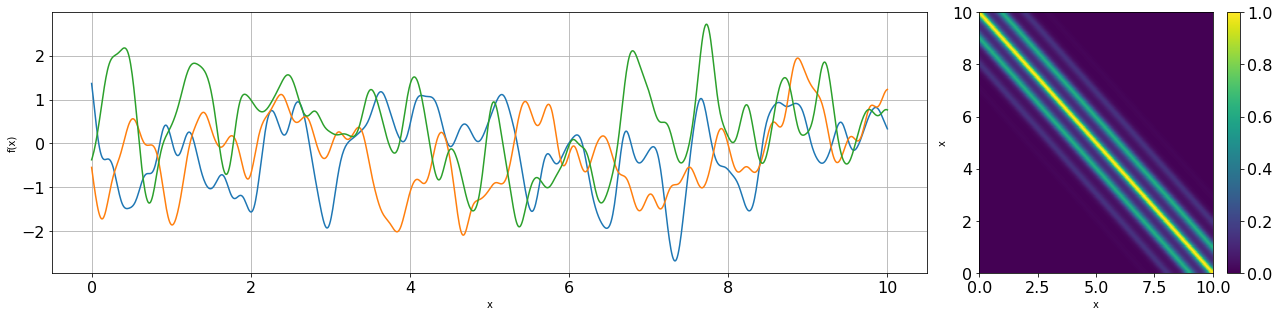

In [9]:
fig2, ax2 = plt.subplots(ncols=2, figsize=(18,4.5), gridspec_kw={'width_ratios': [3, 1]})
ax21, ax22 = ax2.flatten()

for i in y_per:
    ax21.plot(x, i)

p_per = ax22.pcolormesh(xx, yy, per_cov)
ax21.set(xlabel=r'x', ylabel=r'f(x)')
ax22.set(xlabel=r'x',ylabel=r'x')
fig2.colorbar(p_per)
fig2.tight_layout()

## Matern

In [37]:
np.random.seed(42)
mat_cov = matern(theta_mat, x)
y_mat = multivariate_normal.rvs(mean=f_avg, cov=mat_cov, size=3)

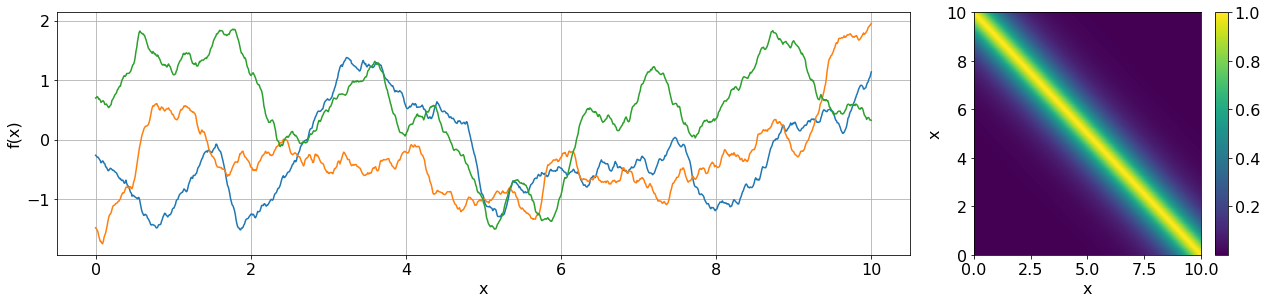

In [38]:
fig3, ax3 = plt.subplots(ncols=2, figsize=(18,4.5), gridspec_kw={'width_ratios': [3, 1]})
ax31, ax32 = ax3.flatten()

for i in y_mat:
    ax31.plot(x, i)

p_mat = ax32.pcolormesh(xx, yy, mat_cov)
ax31.set(xlabel=r'x', ylabel=r'f(x)')
ax32.set(xlabel=r'x',ylabel=r'x')
fig3.colorbar(p_mat)
fig3.tight_layout()

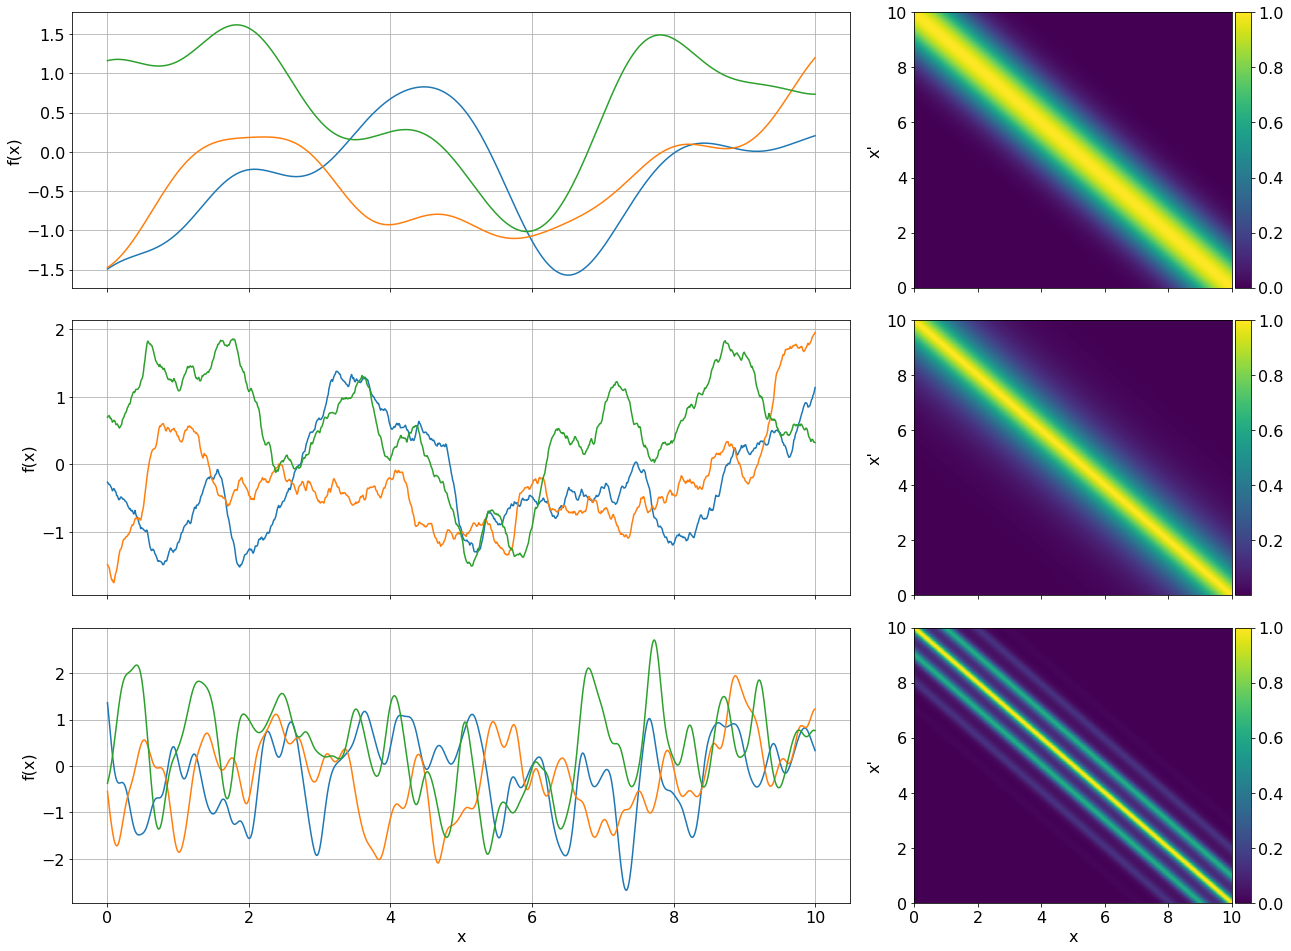

In [39]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


figGP, axGP = plt.subplots(nrows=3, ncols=2, figsize=(18,13.5), sharex='col', gridspec_kw={'width_ratios': [3, 1.3]})

for i in y_rbf:
    axGP[0][0].plot(x, i)
    
for i in y_per:
    axGP[2][0].plot(x, i)
    
for i in y_mat:
    axGP[1][0].plot(x, i)

p_rbf = axGP[0][1].pcolormesh(xx, yy, rbf_cov)
p_per = axGP[2][1].pcolormesh(xx, yy, per_cov)
p_mat = axGP[1][1].pcolormesh(xx, yy, mat_cov)

axGP[2][0].set_xlabel('x')
axGP[2][1].set(xlabel='x', ylabel="x'")
axGP[1][1].set_ylabel("x'")
axGP[0][1].set_ylabel("x'")

axGP[0][0].set_ylabel('f(x)')
axGP[1][0].set_ylabel('f(x)')
axGP[2][0].set_ylabel('f(x)')

colorbar(p_rbf)
colorbar(p_per)
colorbar(p_mat)

figGP.tight_layout()
figGP.savefig('kernel_comparison.png')

# Prior tests

In [4]:
def rbf_logprior(theta, data):
    
    s, l = theta
    diff = np.diff(data[1])
    p_min = np.log10(2*np.min(diff))
    p_max = np.log10(2*np.max(diff))
    
    return uniform.logpdf(s, -2, 4) + uniform.logpdf(l, p_min, p_max-p_min)

def local_periodic_logprior(theta, data):
    
    s, l, p = theta
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    return uniform.logpdf(s, -2, 4) + uniform.logpdf(l, p_min, p_max-p_min) + uniform.logpdf(p, p_min, p_max-p_min)

def matern_logprior(theta, data):
    
    s, nu, l = theta
    diff = np.diff(data[1])
    p_min = np.log10(2*np.min(diff))
    p_max = np.log10(2*np.max(diff))
    
    return uniform.logpdf(s, -2, 4) + uniform.logpdf(nu, -2, 4) + uniform.logpdf(l, p_min, p_max-p_min)

Import B0105 data with structure (XT, X, y, yT, sigmaT, sigma), T denotes test data, and lack of T denotes training data.

In [4]:
pulsar = np.loadtxt('B0105+64.asc', usecols=(0,1,2,7))
data = (pulsar[1::2,0],pulsar[::2,0],pulsar[::2,1],pulsar[1::2,1],pulsar[1::2,2],pulsar[::2,2])

diff = np.diff(data[1])
p_min = np.log10(2*np.min(diff))
p_max = np.log10(2*np.max(diff))

Nens = 1000

s_vals = np.linspace(-3,3, Nens)
l_vals = np.linspace(p_min-1, p_max+1, Nens)
p_vals = np.linspace(p_min-1, p_max+1, Nens)
n_vals = np.linspace(-3,3, Nens)

## RBF

In [17]:
ss, ll = np.meshgrid(s_vals, l_vals)
rbf_prior = np.exp(rbf_logprior([ss, ll], data))

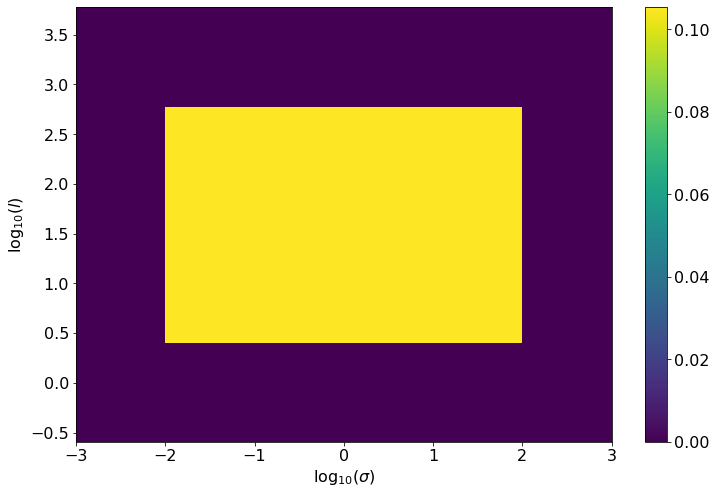

In [18]:
fig4, ax4 = plt.subplots(figsize=(12,8))
p_rbf = ax4.pcolormesh(ss,ll, rbf_prior)
ax4.set(xlabel=r'$\log_{10}(\sigma)$', ylabel='$\log_{10}(l)$')
fig4.colorbar(p_rbf)

# Local Periodic

In [19]:
ss1, ll1 = np.meshgrid(s_vals, l_vals)
ss2, pp2 = np.meshgrid(s_vals, p_vals)
ll3, pp3 = np.meshgrid(l_vals, p_vals)

per_prior1 = np.exp(local_periodic_logprior([ss1, ll1, (p_max+p_min)/2], data))
per_prior2 = np.exp(local_periodic_logprior([ss2, (p_max+p_min)/2, pp2], data))
per_prior3 = np.exp(local_periodic_logprior([0, ll3, pp3], data))

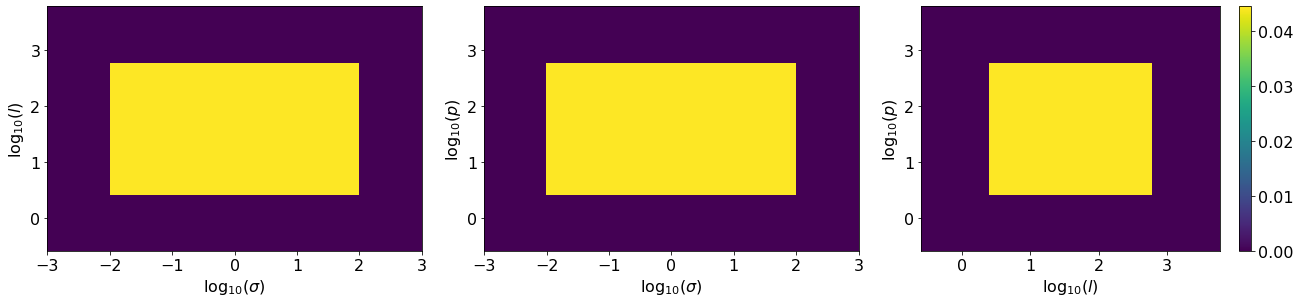

In [20]:
fig5, ax5 = plt.subplots(ncols = 3, figsize=(18.5,4.5))
ax51, ax52, ax53 = ax5.flatten()
p51 = ax51.pcolormesh(ss1, ll1, per_prior1)
p52 = ax52.pcolormesh(ss2, pp2, per_prior2)
p53 = ax53.pcolormesh(ll3, pp3, per_prior3)
fig5.colorbar(p53)
ax51.set(xlabel=r'$\log_{10}(\sigma)$', ylabel=r'$\log_{10}(l)$')
ax52.set(xlabel=r'$\log_{10}(\sigma)$', ylabel=r'$\log_{10}(p)$')
ax53.set(xlabel=r'$\log_{10}(l)$', ylabel=r'$\log_{10}(p)$')
fig5.tight_layout()

## Matern

In [21]:
ss1, ll1 = np.meshgrid(s_vals, l_vals)
ss2, nn2 = np.meshgrid(s_vals, n_vals)
ll3, nn3 = np.meshgrid(l_vals, n_vals)

mat_prior1 = np.exp(matern_logprior([ss1, 0, ll1], data))
mat_prior2 = np.exp(matern_logprior([ss2, nn2, (p_max+p_min)/2], data))
mat_prior3 = np.exp(matern_logprior([0, nn3, ll3], data))

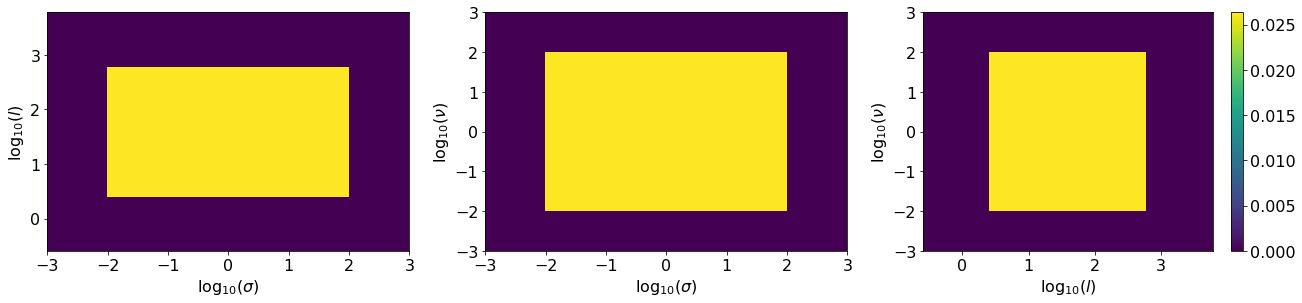

In [22]:
fig6, ax6 = plt.subplots(ncols = 3, figsize=(18.5,4.5))
ax61, ax62, ax63 = ax6.flatten()
p61 = ax61.pcolormesh(ss1, ll1, mat_prior1)
p62 = ax62.pcolormesh(ss2, nn2, mat_prior2)
p63 = ax63.pcolormesh(ll3, nn3, mat_prior3)
fig6.colorbar(p63)
ax61.set(xlabel=r'$\log_{10}(\sigma)$', ylabel=r'$\log_{10}(l)$')
ax62.set(xlabel=r'$\log_{10}(\sigma)$', ylabel=r'$\log_{10}(\nu)$')
ax63.set(xlabel=r'$\log_{10}(l)$', ylabel=r'$\log_{10}(\nu)$')
fig6.tight_layout()

# Initial sample tests

In [23]:
Nens = 10000

def rbf_inisamples(Nens, data):
    
    diff = np.diff(data[1])
    p_min = np.log10(2*np.min(diff))
    p_max = np.log10(2*np.max(diff))
    
    return np.vstack((uniform.rvs(-2,4, size=Nens),uniform.rvs(p_min, p_max-p_min, size=Nens))).T

def local_periodic_inisamples(Nens, data):
    
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    return np.vstack((uniform.rvs(-2,4, size=Nens),
                      uniform.rvs(p_min, p_max-p_min, size=Nens), uniform.rvs(p_min, p_max-p_min, size=Nens))).T

def matern_inisamples(Nens, data):
    
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    return np.vstack((uniform.rvs(-2, 4, size=Nens),
                      uniform.rvs(-2, 4, size=Nens), uniform.rvs(p_min, p_max-p_min, size=Nens))).T

## RBF

In [24]:
np.random.seed(42)
rbf_samples = rbf_inisamples(Nens, data)
rbf_n_params = np.shape(rbf_samples)[1]

[Text(0.5, 0, '$\\log_{10}(l)$')]

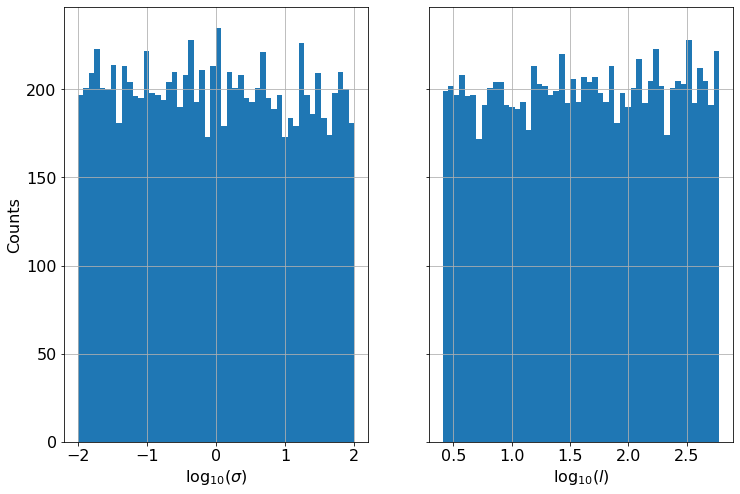

In [25]:
fig7, ax7 = plt.subplots(ncols=rbf_n_params, figsize=(12,8), sharey=True)
for i in range(rbf_n_params):
    ax7[i].hist(rbf_samples[:,i], bins=50)
ax7[0].set(xlabel=r'$\log_{10}(\sigma)$', ylabel='Counts')
ax7[1].set(xlabel=r'$\log_{10}(l)$')

## Local Periodic

In [26]:
np.random.seed(42)
per_samples = local_periodic_inisamples(Nens, data)
per_n_params = np.shape(per_samples)[1]

[Text(0.5, 0, '$\\log_{10}(p)$')]

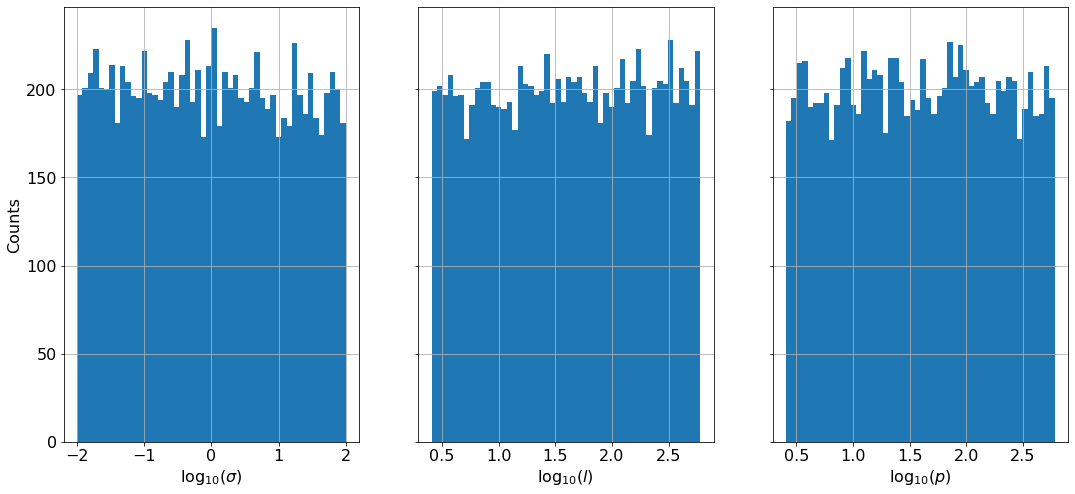

In [27]:
fig8, ax8 = plt.subplots(ncols=per_n_params, figsize=(18,8), sharey=True)
for i in range(per_n_params):
    ax8[i].hist(per_samples[:,i], bins=50)
ax8[0].set(xlabel=r'$\log_{10}(\sigma)$', ylabel='Counts')
ax8[1].set(xlabel=r'$\log_{10}(l)$')
ax8[2].set(xlabel=r'$\log_{10}(p)$')

## Matern

In [28]:
np.random.seed(42)
mat_samples = matern_inisamples(Nens, data)
mat_n_params = np.shape(mat_samples)[1]

[Text(0.5, 0, '$\\log_{10}(l)$')]

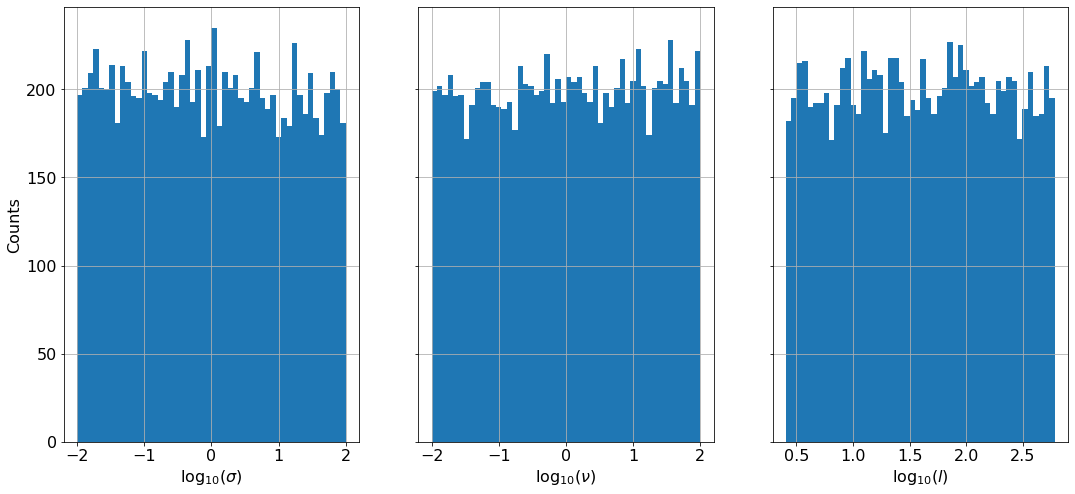

In [29]:
fig9, ax9 = plt.subplots(ncols=mat_n_params, figsize=(18,8), sharey=True)
for i in range(mat_n_params):
    ax9[i].hist(mat_samples[:,i], bins=50)
ax9[0].set(xlabel=r'$\log_{10}(\sigma)$', ylabel='Counts')
ax9[1].set(xlabel=r'$\log_{10}(\nu)$')
ax9[2].set(xlabel=r'$\log_{10}(l)$')

# GP Implementation test

In [30]:
def GP(kernel, theta, data, mu_prior=[], sigma=[]):
    
    
    # Define test points (XT) and training data (X, y)
    XT, X, y = data
    n = len(X)
    
    # Calculate cov. matrix for join distribution
    K = kernel(10**theta, np.concatenate((X, XT)))
    
    # For non-noisy training data set sigma = 0
    if len(sigma)==0:
        sigma = np.zeros(n)
    if len(mu_prior)==0:
        mu_prior = np.zeros(n)
    
    # Sub-matrices of joint distribution, using cholesky decomp. for inversion
    K_XTX = K[n:,:n]
    K_XX = K[:n,:n]+np.diag(sigma**2)
    try:
        ch_K_XX = cholesky(K_XX, lower=True)
    except:
        j = np.concatenate((X,XT))
        u = np.sqrt(2 * theta[0]) * abs(np.subtract.outer(j,j) / theta[1])
        u[u == 0.0] += np.finfo(float).eps
        u = np.diag(u)
        K_tmp = 2**(1-theta[0]) / gamma_func(theta[0]) * (u)**theta[0] * kv(theta[0], u)
        print(u)
        print(K_tmp)
        print(np.count_nonzero(np.isnan(K_tmp)))

    K_XX_inv = inv(ch_K_XX.T) @ inv(ch_K_XX)#inv(K[:n,:n]+np.diag(sigma**2))
    K_XXT = K[:n,n:]
    K_XTXT = K[n:,n:]
    
    # Find conditioned mean function and covariance matrix
    m = K_XTX @ K_XX_inv @ (y-mu_prior)
    K = K_XTXT - K_XTX @ K_XX_inv @ K_XXT
    
    return (m, np.sqrt(np.diag(K)))

Generate data using MC sampling.

In [117]:
def func(x):
    x = x/100
    return x*np.sin(x)+10

N_points = 100000
samples = np.zeros(N_points)

np.random.seed(42)
for i in range(N_points):
    
    while True:
        
        x = uniform.rvs(0,1000)
        y = uniform.rvs(0, 18)
        
        if y<func(x):
            samples[i] = x
            break

In [120]:
counts, bin_edges = np.histogram(samples, bins=200, range=(0, 1000))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

A = (10000+100*np.sin(10)-1000*np.cos(10))**-1
N = N_points*np.diff(bin_centers)[0]

x_f = bin_centers[counts > 0]
y_f = 1/(A*N) * counts[counts > 0]
s_f = 1/(A*N) * s_counts[counts > 0]

In [121]:
data_y = [x_f[1::2], x_f[::2], y_f[::2], y_f[1::2], s_f[1::2], s_f[::2]] # (XT, X, y, yT, sigmaT, sigma)

theta_rbf = np.array([0.,2.]) #s, l 0.3,2.4
theta_per = np.array([0.,2.,0.4]) # s, l, p
theta_mat = np.array([0.,-0.69,2.]) # s, nu, l

## RBF

In [122]:
y_rbf, y_rbf_sigma = GP(rbf, theta_rbf, data_y[:3], sigma=data_y[5])

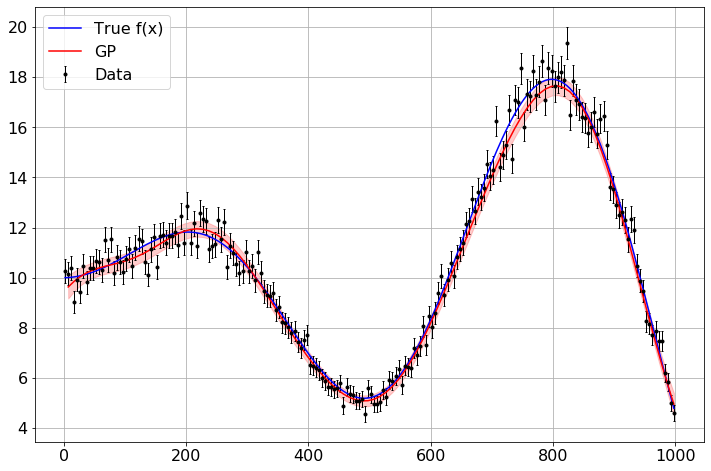

In [123]:
fig10, ax10 = plt.subplots(figsize=(12,8))
ax10.errorbar(x_f, y_f, yerr=s_f, fmt='.k', ecolor='k', elinewidth=1, capsize=1, capthick=1, label='Data')
ax10.plot(x_f, func(x_f), color='b', label='True f(x)')
ax10.plot(data_y[0], y_rbf, c='r', label='GP')
ax10.fill_between(data_y[0], y_rbf+2*y_rbf_sigma, y_rbf-2*y_rbf_sigma, color='r', alpha=0.2)
ax10.legend()

## Local Periodic

In [124]:
y_per, y_per_sigma = GP(local_periodic, theta_per, data_y[:3], sigma=data_y[5])

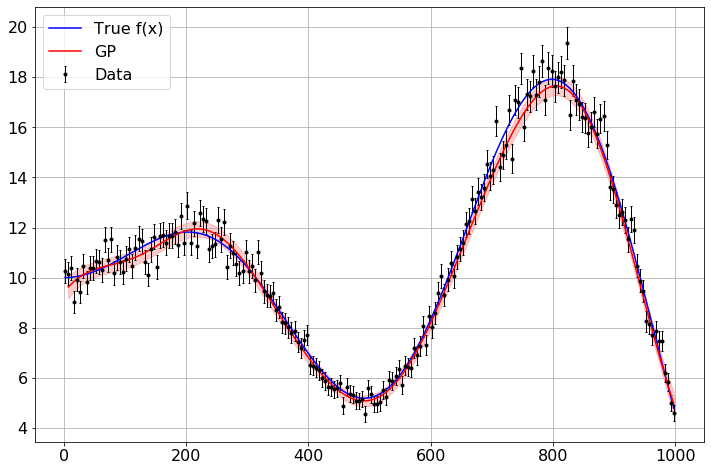

In [125]:
fig11, ax11 = plt.subplots(figsize=(12,8))
ax11.errorbar(x_f, y_f, yerr=s_f, fmt='.k', ecolor='k', elinewidth=1, capsize=1, capthick=1, label='Data')
ax11.plot(x_f, func(x_f), color='b', label='True f(x)')
ax11.plot(data_y[0], y_per, c='r', label='GP')
ax11.fill_between(data_y[0], y_per+2*y_per_sigma, y_per-2*y_per_sigma, color='r', alpha=0.2)
ax11.legend()

## Matern

In [38]:
y_mat, y_mat_sigma = GP(matern, theta_mat, data_y[:3], sigma=data_y[5])

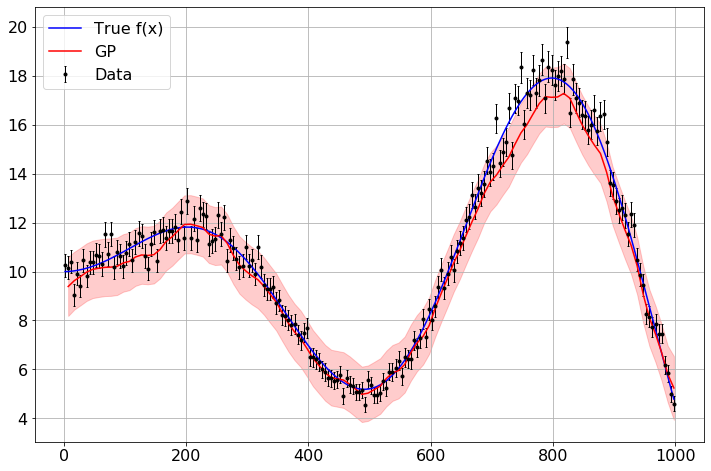

In [39]:
fig12, ax12 = plt.subplots(figsize=(12,8))
ax12.errorbar(x_f, y_f, yerr=s_f, fmt='.k', ecolor='k', elinewidth=1, capsize=1, capthick=1, label='Data')
ax12.plot(x_f, func(x_f), color='b', label='True f(x)')
ax12.plot(data_y[0], y_mat, c='r', label='GP')
ax12.fill_between(data_y[0], y_mat+2*y_mat_sigma, y_mat-2*y_mat_sigma, color='r', alpha=0.2)
ax12.legend()

# Test of script

In [136]:
def loglikelihood(theta, data, kernel=rbf):
    
    """Data has structure (XT, X, y, yT, sigmaT, sigma)"""

    # normalisation
    norm = -0.5*len(data[0])*np.log(2*np.pi) - np.sum(np.log(data[4]))

    # chi-squared
    chisq = np.sum(((data[3]-GP(kernel, theta, data[:3], sigma=data[5])[0])/data[4])**2)

    return norm - 0.5*chisq



kernel_info = {'RBF': {'ndims': 2, 'kernel': rbf, 'logprior': rbf_logprior, 
                       'inisamples': rbf_inisamples},
               'Local_Periodic': {'ndims': 3, 'kernel': local_periodic, 'logprior': local_periodic_logprior,
                                  'inisamples': local_periodic_inisamples}, 
               'Matern': {'ndims': 3, 'kernel': matern, 'logprior': matern_logprior,
                          'inisamples': matern_inisamples}}

Nens = 100
Nburnin = 500
Nsamples = 500

## RBF

In [41]:
kernel_name = 'RBF'

logprior = kernel_info[kernel_name]['logprior']
kernel = kernel_info[kernel_name]['kernel']

In [42]:
def logposterior(theta): #data, logprior, kernel=rbf):
    
    global data_y
    global logprior
    global kernel
    global data

    lp = logprior(theta, data)
    
    if not np.isfinite(lp):
        
        return -np.inf
    
    #print(loglikelihood(theta, data_y, kernel=kernel))
    
    return lp + loglikelihood(theta, data_y, kernel=kernel)

In [43]:
ndims = kernel_info[kernel_name]['ndims']

inisamples = kernel_info[kernel_name]['inisamples'](Nens, data) 

# set up the sampler
sampler = em.EnsembleSampler(Nens, ndims, logposterior)
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

In [44]:
acl = sampler.get_autocorr_time(c=1, quiet=True)
print("The autocorrelation lengths are %s" %(acl))

samples_rbf = sampler.chain[:, Nburnin::int(max(acl)), :].reshape((-1, ndims))
print("Number of independent samples is {}".format(len(samples_rbf)))

N/50 = 20;
tau: [23.49091371 20.40753217]


The autocorrelation lengths are [23.49091371 20.40753217]
Number of independent samples is 2200


In [61]:
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    
    fig = corner.corner(samples, labels=[r'$\log_{10}(\sigma)$', r'$\log_{10}(\nu)$', r'$\log_{10}(l)$'], 
                        hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    #for axidx, samps in zip([0, 3], samples.T):
    #    kde = gaussian_kde(samps)
    #    xvals = fig.axes[axidx].get_xlim()
    #    xvals = np.linspace(xvals[0], xvals[1], 100)
    #    fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

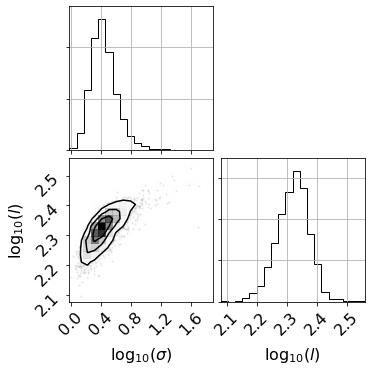

In [60]:
plotposts(samples_rbf)

## Local Periodic

In [46]:
kernel_name = 'Local_Periodic'

logprior = kernel_info[kernel_name]['logprior']
kernel = kernel_info[kernel_name]['kernel']

In [47]:
def logposterior(theta): #data, logprior, kernel=rbf):
    
    global data_y
    global logprior
    global kernel
    global data

    lp = logprior(theta, data)
    
    if not np.isfinite(lp):
        
        return -np.inf
    
    #print(loglikelihood(theta, data_y, kernel=kernel))
    
    return lp + loglikelihood(theta, data_y, kernel=kernel)

In [48]:
ndims = kernel_info[kernel_name]['ndims']

inisamples = kernel_info[kernel_name]['inisamples'](Nens, data) 

# set up the sampler
sampler = em.EnsembleSampler(Nens, ndims, logposterior)
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt


In [49]:
acl = sampler.get_autocorr_time(c=1, quiet=True)
print("The autocorrelation lengths are %s" %(acl))

samples_per = sampler.chain[:, Nburnin::int(max(acl)), :].reshape((-1, ndims))
print("Number of independent samples is {}".format(len(samples_per)))

N/50 = 20;
tau: [26.60925024 24.57527938 35.50017355]


The autocorrelation lengths are [26.60925024 24.57527938 35.50017355]
Number of independent samples is 1500


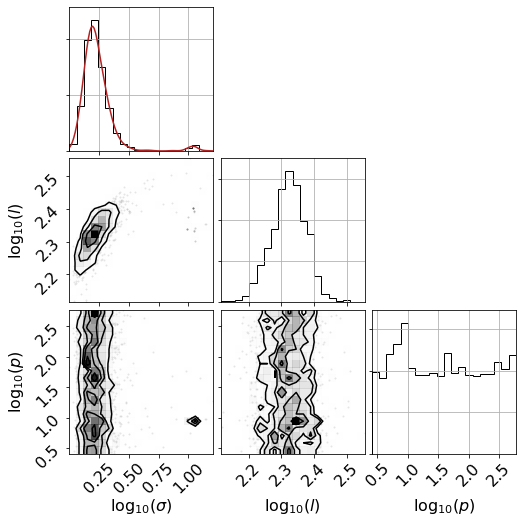

In [50]:
plotposts(samples_per)

## Matern

In [51]:
kernel_name = 'Matern'

logprior = kernel_info[kernel_name]['logprior']
kernel = kernel_info[kernel_name]['kernel']

In [52]:
def logposterior(theta): #data, logprior, kernel=rbf):
    
    global data_y
    global logprior
    global kernel
    global data

    lp = logprior(theta, data)
    
    if not np.isfinite(lp):
        
        return -np.inf
    
    #print(loglikelihood(theta, data_y, kernel=kernel))
    
    return lp + loglikelihood(theta, data_y, kernel=kernel)

In [53]:
ndims = kernel_info[kernel_name]['ndims']

inisamples = kernel_info[kernel_name]['inisamples'](Nens, data) 

# set up the sampler
sampler = em.EnsembleSampler(Nens, ndims, logposterior)
sampler.run_mcmc(inisamples, Nsamples+Nburnin);

In [54]:
acl = sampler.get_autocorr_time(c=1, quiet=True)
print("The autocorrelation lengths are %s" %(acl))

samples_mat = sampler.chain[:, Nburnin::int(max(acl)), :].reshape((-1, ndims))
print("Number of independent samples is {}".format(len(samples_mat)))

N/50 = 20;
tau: [47.65004859 52.66150772 32.66087697]


The autocorrelation lengths are [47.65004859 52.66150772 32.66087697]
Number of independent samples is 1000


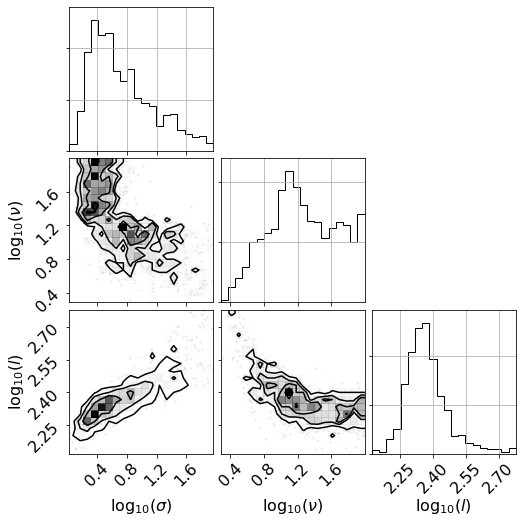

In [62]:
plotposts(samples_mat)

In [144]:
theta_per = np.array([0.,2.,2.76])
loglikelihood(theta_per,data, kernel=local_periodic)

-861.7583550830872

TEST EMCEE SAMPLING DIRECTLY FROM PRIOR (FLAT LIKELIHOOD / LIKELIHOOD=1)